In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os 
os.chdir('/content/drive/MyDrive/GoEmotions_PyTorch')

In [58]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [26]:
transcript = pd.read_csv('transcripts/transcripts.csv', delimiter='|')
qna =  pd.read_csv('transcripts/QnA.csv', delimiter='|')

# Merge the two dataframes
df = pd.merge(transcript, qna[['transcript','filename']], on='filename')

# rename transcript_x to presentation and transcript_y to QnA
df = df.rename(columns={'transcript_x': 'presentation', 'transcript_y': 'QnA'})

mapping = pd.read_csv('data/mapping.csv')

# create a new column 'AllNames' that concatenates all versions of 'Company' for a 'CompanyName'
mapping['AllNames'] = mapping.groupby('RR_CompanyName')['Transcript_Mapping'].transform(lambda x: ', '.join(x))
mapping.head()

# Load recovery rates
rr = pd.read_csv('data/RR_Bonds.csv')
rr = rr[['Ddate', 'RR', 'CompanyName', 'CUSIP', 'LTDIssuance2', 'Intangibility', 'Receivables1']]

preprocessed_df = pd.read_csv('data/preprocessed_bond_data.csv')

# Add rr columns to preprocessed_df on index
preprocessed_df['RR'] = rr['RR']
preprocessed_df['Ddate'] = rr['Ddate']
preprocessed_df['CompanyName'] = rr['CompanyName']
preprocessed_df['CUSIP'] = rr['CUSIP']
preprocessed_df['LTDIssuance2'] = rr['LTDIssuance2']
preprocessed_df['Intangibility'] = rr['Intangibility']
preprocessed_df['Receivables1'] = rr['Receivables1']

rr = preprocessed_df

# Convert 'Date' column to datetime
rr['Ddate'] = pd.to_datetime(rr['Ddate'], errors='coerce')
rr.head()

# merge rr with mapping on CompanyName and RR_CompanyName
rr = rr.merge(mapping, left_on='CompanyName', right_on='RR_CompanyName')

# join with df on Company and Transcripts_Mapping
merged_df = rr.merge(df, left_on='Transcript_Mapping', right_on='Company')
print(merged_df['CompanyName'].value_counts())

# Ensure the columns are in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Ddate'] = pd.to_datetime(merged_df['Ddate'])

# Compute the difference in days
merged_df['diff'] = (merged_df['Ddate'] - merged_df['Date']).dt.days

merged_df = merged_df[merged_df['Ddate']>merged_df['Date']]
merged_df = merged_df.sort_values(by='Date').groupby(['CUSIP']).tail(1)

print(merged_df['CompanyName'].value_counts())

Ally Financial Inc.               10317
CIT Group Inc.                    10185
Lehman Brothers Holdings, Inc.     2853
Charter Communications, Inc.       2144
Sempra Energy                      1147
                                  ...  
Frontier Group Holdings, Inc.         1
Dayton Superior Corporation           1
Franklin Bank Corp.                   1
Kellwood Company, LLC                 1
Turning Point Brands, Inc.            1
Name: CompanyName, Length: 210, dtype: int64
Lehman Brothers Holdings, Inc.      317
CIT Group Inc.                      291
Charter Communications, Inc.         28
Ford Motor Company                   19
iStar Inc.                           17
                                   ... 
Centrus Energy Corp.                  1
Education Management Corporation      1
Venoco, Inc.                          1
Exelon Corporation                    1
Kellwood Company, LLC                 1
Name: CompanyName, Length: 159, dtype: int64


In [29]:
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

# Initialize stemmer
stemmer = SnowballStemmer("english")

# Keywords for each credit factor
credit_keywords = pd.read_csv('data/credit_dictionary.csv')
credit_keywords = credit_keywords['word']

# Function to identify sections with potential bankruptcy indicators
def identify_bankruptcy_indicators(transcript, keywords):
    sentences = nltk.sent_tokenize(transcript)
    indicator_sentences = []
    for sentence in sentences:
        if any(re.search(r'\b' + re.escape(word) + r'\b', sentence, re.IGNORECASE) for word in keywords):
            indicator_sentences.append(sentence)

    return ' '.join(indicator_sentences)

# Function to clean text by stemming and replacing numbers with magnitude tokens
def clean_text(text):
    # Replace numbers with tokens
    text = re.sub(r'\b\d+(\.\d+)?\s?(billion|bln)\b', 'bln', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d+(\.\d+)?\s?(million|mln)\b', 'mln', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d{1,3}(,\d{3})*(\.\d+)?\b', 'num', text)  # Replace remaining numbers with 'num'
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize, stem, and rejoin
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words if len(word) > 1]  # Remove single characters that might be noise
    return ' '.join(stemmed_words)

# Transform transcript to lowercase
merged_df['presentation'] = merged_df['presentation'].str.lower()
merged_df['QnA'] = merged_df['QnA'].str.lower()

# Apply function to identify bankruptcy indicators
merged_df['presentation_cleaned'] = merged_df['presentation'].apply(lambda x: identify_bankruptcy_indicators(x, credit_keywords))
merged_df['QnA_cleaned'] = merged_df['QnA'].apply(lambda x: identify_bankruptcy_indicators(x, credit_keywords))

# reset index
merged_df.reset_index(drop=True, inplace=True)

In [30]:
merged_df.to_csv('transcripts/credit_df.csv', index=False, sep='|')


In [47]:
df = merged_df.copy()

# count unique transcripts in transcripts['Cleaned_Bankruptcy_Indicators']
print(df['presentation_cleaned'].nunique())

# add a number to each transcript based on the 196 unique transcripts
df['transcript_number'] = df['presentation_cleaned'].factorize()[0]

number_transcript = df[['transcript_number', 'presentation_cleaned']].drop_duplicates().sort_values('transcript_number')

number_transcript.head()

number_transcript = number_transcript.dropna()

194


In [48]:
emotion_scores = pd.read_csv('goemotions/emotion_scores.csv')

# add column transcript_number to emotion_scores which equals index
emotion_scores['transcript_number'] = emotion_scores.index

In [49]:
# merge emotion_scores with number_transcript on transcript_number
emotion_scores = emotion_scores.merge(number_transcript, on='transcript_number')
emotion_scores.head()

,Unnamed: 0,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,transcript_number,presentation_cleaned
0,0,0.040107,0.0,0.0,0.0,0.171378,0.0,0.000000,0.0,0.000000,...,0.0,0.049771,0.000000,0.050679,0.000000,0.0,0.0,0.0,0,"as you know, on september 18th, kellwood recei..."
1,1,0.117790,0.0,0.0,0.0,0.147036,0.0,0.008159,0.0,0.005284,...,0.0,0.112821,0.008622,0.021523,0.000000,0.0,0.0,0.0,1,"secondly, we're going to be\nallowing one ques..."
2,2,0.074449,0.0,0.0,0.0,0.100436,0.0,0.000000,0.0,0.000000,...,0.0,0.057484,0.000000,0.058981,0.005795,0.0,0.0,0.0,2,frontier assumes\nno obligation to update this...
3,3,0.107963,0.0,0.0,0.0,0.112489,0.0,0.000000,0.0,0.000000,...,0.0,0.073672,0.000000,0.049135,0.013104,0.0,0.0,0.0,3,"with me\ntoday are; dick bond, our president a..."
4,4,0.030215,0.0,0.0,0.0,0.149368,0.0,0.000000,0.0,0.000000,...,0.0,0.091103,0.000000,0.036095,0.009314,0.0,0.0,0.0,4,bob will then\nreview the financial performanc...


In [50]:
# merge emotion_scores with df on emotion_scores['transcript_number'] == df['transcript_number']
emotion_scores = emotion_scores.merge(df, on='transcript_number')

In [51]:
emotion_scores.head()

,Unnamed: 0,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,filename,presentation,Company,Quarter,Year,Date,QnA,diff,presentation_cleaned_y,QnA_cleaned
0,0,0.040107,0.0,0.0,0.0,0.171378,0.0,0.000000,0.0,0.000000,...,"Kellwood Company, Q3 2007 Earnings Call, Dec-0...",presentation\noperator\ngood morning ladies an...,Kellwood Company,Q3,2007.0,2006-12-01,question and answer\noperator\n[operator instr...,957,"as you know, on september 18th, kellwood recei...",question and answer\noperator\n[operator instr...
1,1,0.117790,0.0,0.0,0.0,0.147036,0.0,0.008159,0.0,0.005284,...,"Nortel Networks Corp., Q3 2007 Earnings Call, ...","presentation\noperator\nladies and gentlemen, ...",Nortel Networks Corp.,Q3,2007.0,2007-11-06,question and answer\noperator\n(operator instr...,435,"secondly, we're going to be\nallowing one ques...","mike, this is obviously a margin story quarter..."
2,2,0.074449,0.0,0.0,0.0,0.100436,0.0,0.000000,0.0,0.000000,...,"Frontier Airlines Holdings, Inc., Q3 2008 Earn...",presentation\noperator\ngreetings ladies and g...,"Frontier Airlines Holdings, Inc.",Q3,2008.0,2008-01-25,question and answer\noperator\nthank you. ladi...,253,frontier assumes\nno obligation to update this...,is it\nconsumer demand; is it competition from...
3,3,0.107963,0.0,0.0,0.0,0.112489,0.0,0.000000,0.0,0.000000,...,"Tyson Foods Inc., Q1 2008 Earnings Call, Jan-2...","presentation\noperator\nthank you, all parties...",Tyson Foods Inc.,Q1,2008.0,2008-01-28,question and answer\noperator\n[operator instr...,69,"with me\ntoday are; dick bond, our president a...","richard l. bond\ngood morning, diane. diane ge..."
4,4,0.030215,0.0,0.0,0.0,0.149368,0.0,0.000000,0.0,0.000000,...,"Silgan Holdings Inc., Q4 2007 Earnings Call, J...",presentation\noperator\nthank you for joining ...,Silgan Holdings Inc.,Q4,2007.0,2008-01-30,question and answer\noperator\n(operator instr...,175,bob will then\nreview the financial performanc...,george staphos\nbanc of america securities\ni ...


In [52]:
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 
    'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise'
]

# keep only the emotions columns and RR
emotion_scores = emotion_scores[['RR'] + emotions]

In [55]:
final_df = emotion_scores.copy()

In [57]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     25.94
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           2.27e-86
Time:                        11:18:33   Log-Likelihood:                -4771.0
No. Observations:                1073   AIC:                             9590.
Df Residuals:                    1049   BIC:                             9709.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.9176      2.892      5.

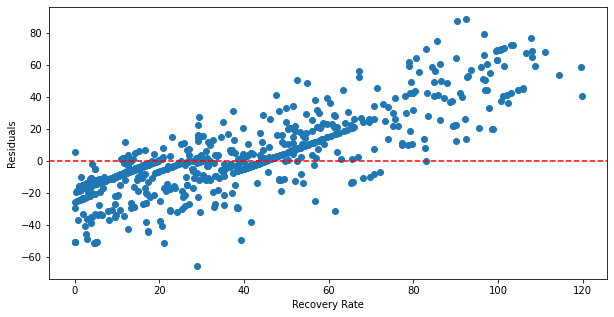

In [59]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()